Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8196 - loss: 3.8797 - val_accuracy: 1.0000 - val_loss: 3.9224e-08
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9184 - loss: 0.5084 - val_accuracy: 1.0000 - val_loss: 7.5027e-33
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8987 - loss: 0.5123 - val_accuracy: 1.0000 - val_loss: 8.0992e-36
Epoch 4/10


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9170 - loss: 0.2436 - val_accuracy: 1.0000 - val_loss: 3.3442e-20
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9366 - loss: 0.1688 - val_accuracy: 1.0000 - val_loss: 9.1816e-24
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9140 - loss: 0.2349 - val_accuracy: 1.0000 - val_loss: 1.2540e-19
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9283 - loss: 0.1915 - val_accuracy: 1.0000 - val_loss: 2.6179e-14
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9221 - loss: 0.1914 - val_accuracy: 1.0000 - val_loss: 6.3312e-16
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9305 - loss: 0.1579 - val_accuracy: 1.0000 - val_loss: 2.7457e-14
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9237 - loss: 0.1587 - val_accuracy: 1.0000 - val_loss: 1.3283e-13


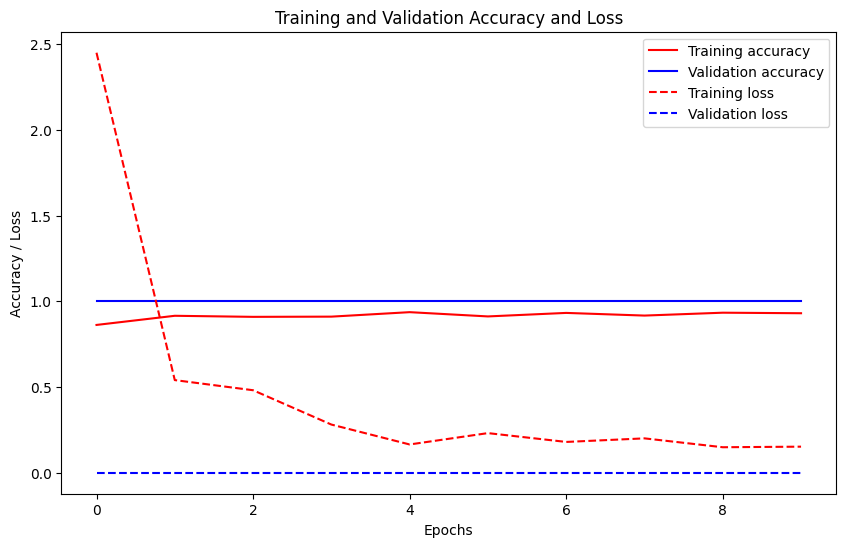

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2

# 데이터 경로 설정
data_dir = "datasets/horse-or-human/"
img_size = (300, 300)


# 데이터셋을 불러와 정규화하는 함수
def load_and_preprocess_images(data_dir):
    images = []
    labels = []

    # 디렉토리에서 이미지와 레이블 불러오기
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0  # 정규화
                images.append(img_array)
                labels.append(0 if label_dir == "horses" else 1)  # horse: 0, human: 1

    return np.array(images), np.array(labels)


# 랜덤 회전 각도 적용을 위한 사용자 정의 함수
def random_rotation(x):
    angles = [90, 135, 180, 225, 270]
    angle = np.random.choice(angles)
    return tf.keras.preprocessing.image.random_rotation(x, angle)


# 이미지와 레이블 불러오기
images, labels = load_and_preprocess_images(data_dir)

# Train/Validation 데이터셋 8:2로 나누기
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# 원본 train 데이터를 추가하기 위한 ImageDataGenerator (변형 없이 사용)
original_datagen = ImageDataGenerator()

# 변형된 train 데이터를 만들기 위한 ImageDataGenerator (7가지 변형 중 랜덤 회전 포함)
augmented_datagen = ImageDataGenerator(
    preprocessing_function=random_rotation,  # 사용자 정의 회전 함수 추가
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    shear_range=0.2,  # 찌그러뜨리기
    zoom_range=0.2,  # 크기 변형
    horizontal_flip=True,  # 좌우 반전
    fill_mode="nearest",  # 빈 픽셀 채우기
)

# 원본 train 데이터는 변형 없이 학습시키고, 변형된 데이터를 추가로 학습시킴
original_generator = original_datagen.flow(X_train, y_train, batch_size=16)
augmented_generator = augmented_datagen.flow(X_train, y_train, batch_size=16)

# 검증 데이터는 변형 없이 사용
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=16)

# Xception 모델 불러오기 (사전 학습된 가중치 사용)
base_model = Xception(weights="imagenet", include_top=False, input_shape=(300, 300, 3))

# 사전 학습된 층은 훈련되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))  # 이진 분류이므로 sigmoid 활성화 함수

# 모델 컴파일
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 학습 과정에서 원본 데이터와 변형된 데이터를 함께 사용
total_steps_per_epoch = (
    len(X_train) // 16
)  # 원본 + 변형된 데이터로 총 5배의 데이터셋


def combined_generator(original_gen, augmented_gen):
    while True:
        original_data = next(original_gen)  # generator에서 데이터를 가져옴
        augmented_data = next(augmented_gen)  # generator에서 데이터를 가져옴
        combined_data = np.concatenate([original_data[0], augmented_data[0]], axis=0)
        combined_labels = np.concatenate([original_data[1], augmented_data[1]], axis=0)
        yield combined_data, combined_labels


# 모델 학습
history = model.fit(
    combined_generator(original_generator, augmented_generator),
    steps_per_epoch=total_steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
)

# 학습 결과 시각화
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
# 정확도 시각화
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")

# 손실 시각화
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b--", label="Validation loss")

# 그래프 제목 및 레이블 설정
plt.title("Training and Validation Accuracy and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend()

# 그래프 표시
plt.show()

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6537 - loss: 0.6075 - val_accuracy: 0.9883 - val_loss: 0.0713
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7812 - loss: 0.3404
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8044 - loss: 0.3734 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step - accuracy: 0.9375 - loss: 0.2602
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8458 - loss: 0.2990 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 1.0000 - loss: 0.4172 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8558 - loss: 0.3084 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 518us/step - accuracy: 0.8125 - loss: 0.3333
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8654 -

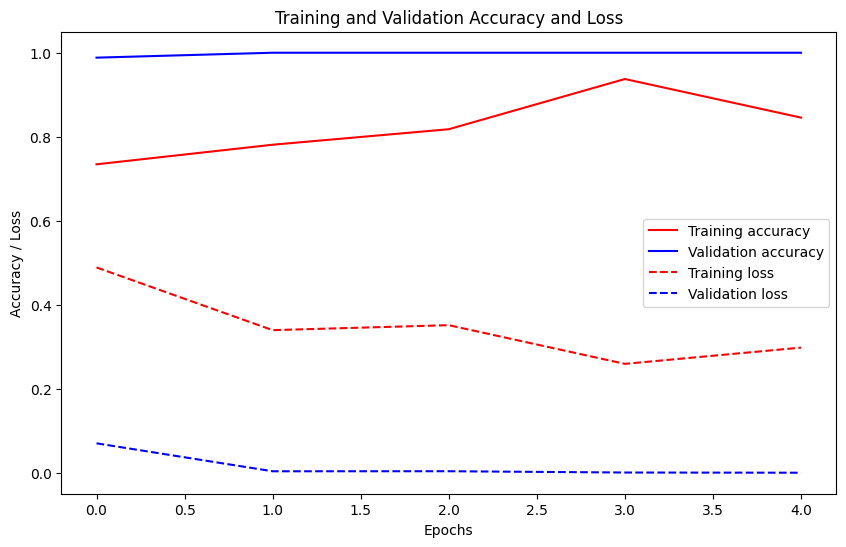

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
from tensorflow.keras.optimizers import Adam

# 데이터셋 경로 지정
train_horse_dir = "./datasets/horse-or-human/horses"
train_human_dir = "./datasets/horse-or-human/humans"

# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + "/" + f for f in train_horse_names]
human_files = [train_human_dir + "/" + f for f in train_human_names]

# 말과 사람의 클래스별 비율 계산
total_horses = len(os.listdir("./datasets/horse-or-human/horses"))
total_humans = len(os.listdir("./datasets/horse-or-human/humans"))

# 각 클래스의 비율 계산
class_weight = {
    0: total_humans / total_horses,  # 말 클래스에 가중치 부여
    1: total_horses / total_humans,  # 사람 클래스에 가중치 부여
}


# 랜덤 회전 각도 적용을 위한 사용자 정의 함수
def random_rotation(x):
    angles = [90, 135, 180, 225, 270]
    angle = np.random.choice(angles)
    return tf.keras.preprocessing.image.random_rotation(x, angle)


train_datagen = ImageDataGenerator(
    rescale=1 / 255,  # 0~1 사이로 픽셀 값 정규화
    preprocessing_function=random_rotation,  # 사용자 정의 회전 함수 추가
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    shear_range=0.2,  # 찌그러뜨리기
    zoom_range=0.2,  # 크기 변형
    horizontal_flip=True,  # 좌우 반전
    fill_mode="nearest",  # 빈 픽셀 채우기
)

valid_datagen = ImageDataGenerator(rescale=1 / 255)

# train set
train_generator = train_datagen.flow_from_directory(
    "./datasets/horse-or-human/",
    target_size=(300, 300),  # 해상도 조절
    batch_size=32,  # 배치 크기
    class_mode="binary",  # 분류 방법
)
# valid set
valid_generator = valid_datagen.flow_from_directory(
    "./datasets/validation-horse-or-human/",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary",
)

# Xception 모델 불러오기 (사전 학습된 가중치 사용)
base_model = Xception(weights="imagenet", include_top=False, input_shape=(300, 300, 3))

# 사전 학습된 층은 훈련되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))  # 이진 분류이므로 sigmoid 활성화 함수

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    class_weight=class_weight,  # 클래스 가중치 적용
    epochs=10,
    verbose=1,
)

# 시각화 코드 (배열 길이를 동적으로 설정)
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# 학습 결과 시각화
epochs = range(min(len(acc), len(val_acc)))  # 각 배열의 길이에 맞춤

plt.figure(figsize=(10, 6))
# 정확도 시각화
plt.plot(epochs, acc[:len(epochs)], "r", label="Training accuracy")
plt.plot(epochs, val_acc[:len(epochs)], "b", label="Validation accuracy")

# 손실 시각화
plt.plot(epochs, loss[:len(epochs)], "r--", label="Training loss")
plt.plot(epochs, val_loss[:len(epochs)], "b--", label="Validation loss")

plt.title("Training and Validation Accuracy and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend()

plt.show()

In [7]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score

# 이미지 경로 설정
dlist = "./datasets/test/"
predict_list = os.listdir(dlist)

# 이미지 불러오기 및 전처리
img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300, 300)) for i in img]
img = np.array(img)
img = img.astype("float32") / 255.0

# 예측
cutoff = 0.5
predictions = model.predict(img)

# 예측 결과 출력
for i, pred in enumerate(predictions):
    label = "human" if pred >= cutoff else "horse"
    confidence = pred[0] * 100 if pred >= cutoff else (1 - pred[0]) * 100
    print(
        f"Image: {predict_list[i]} -> Predicted: {label}, Confidence: {confidence:.2f}%"
    )

# 정확도 계산 (23개의 말과 23개의 사람 레이블)
true_labels = [0] * 23 + [1] * 23  # 0: horse, 1: human
predicted_labels = [1 if pred >= cutoff else 0 for pred in predictions]

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step
Image: horse_01.jpeg -> Predicted: horse, Confidence: 99.88%
Image: horse_02.jpeg -> Predicted: horse, Confidence: 99.97%
Image: horse_03.jpeg -> Predicted: horse, Confidence: 99.94%
Image: horse_04.jpg -> Predicted: horse, Confidence: 99.97%
Image: horse_05.jpg -> Predicted: horse, Confidence: 99.79%
Image: horse_06.jpg -> Predicted: horse, Confidence: 99.64%
Image: horse_07.jpg -> Predicted: horse, Confidence: 97.74%
Image: horse_08.jpg -> Predicted: horse, Confidence: 99.80%
Image: horse_09.jpg -> Predicted: horse, Confidence: 99.22%
Image: horse_10.jpg -> Predicted: horse, Confidence: 99.52%
Image: horse_11.jpg -> Predicted: horse, Confidence: 99.80%
Image: horse_12.jpg -> Predicted: horse, Confidence: 99.72%
Image: horse_13.webp -> Predicted: horse, Confidence: 99.92%
Image: horse_14.jpg -> Predicted: horse, Confidence: 99.96%
Image: horse_15.webp -> Predicted: horse, Confidence: 100.00%
Image: horse_16.jpg -> Predicted: horse, Confidence: 72

In [5]:
model.save("Xception_model_test.keras")